In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data files
* Network has 118 nodes and 169 (concatenated from 176) edges
* Uniform load (input) dataset
* 1 original network and 9 networks with topology disturbances and corresponding solutions
* Network perturbations generated by a random process following a binomial distribution 

* Load nominal system data
- Data pre-stored in pickle files

In [ ]:
filepath = '/content/drive/My Drive/gnn/data/data_118ac_topo_3inputs/'

x = np.load(filepath + 'pickle/ac118_p10_x_nominal.npy')
y = np.load(filepath + 'pickle/ac118_p10_y_nominal.npy')
W = np.load(filepath + 'pickle/ac118_p10_w_nominal.npy')
sys_params = np.load(filepath + 'pickle/ac118_p10_sys_nominal.npy')

## load injection
# system size
n_bus=int(sys_params[0,0].copy())
n_line=int(sys_params[1,0].copy()) # not concatenated
n_line=179
n_load=int(sys_params[2,0].copy())
n_sample=int(sys_params[3,0].copy())
# line
line_bus=sys_params[:,1:3].copy()

print('Nominal system (w/out outage):')
# print('Test case: ',filename)
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples: ',n_sample)

Nominal system (w/out outage):
Number of buses:  118
Number of lines:  179
Number of loads:  99
Number of samples:  7000


* Load perturbed system data

In [ ]:

filename = filepath + 'ieee118ac_topo_topo_effective_index.txt'
effective_index = pd.read_table(filename,sep=',',header=None).to_numpy()
print(effective_index.shape)

topo_pert_num = np.size(effective_index,1) - 1
print('Systems w/ topo. perturb:',topo_pert_num)

effective_samples0 = np.sum(effective_index[:,0],0)
effective_index0 = effective_index[:,0].copy()

effective_samples = np.sum(effective_index[:,1:],0)
print('Nominal effective samples:',effective_samples0)
print('Effective samples for topo. changes:',effective_samples)

(7000, 10)
Systems w/ topo. perturb: 9
Nominal effective samples: 7000
Effective samples for topo. changes: [7000 7000 7000 7000 7000 7000 7000 7000 7000]


In [ ]:
##@title

gen_pert = np.load(filepath + 'pickle/ac118_p10_gen_pert.npy')
lmp_pert = np.load(filepath + 'pickle/ac118_p10_y_pert.npy')

print(gen_pert.shape,lmp_pert.shape)

(9, 118, 7000) (9, 118, 7000)


In [ ]:
#@title
# # Graph generating function
# def build_system_graph(src,dst):
#     # Edges are directional in DGL; Make them bi-directional.
#     # Matlab counts from 1 and python from 0
#     u = np.concatenate([src, dst])-1 
#     v = np.concatenate([dst, src])-1
#     # Construct a DGLGraph
#     return dgl.DGLGraph((u, v))

# line_src = line_bus[:,0].copy()
# line_dst = line_bus[:,1].copy()
# G = build_system_graph(line_src.astype(int),line_dst.astype(int))
# print('There are %d nodes.' % G.number_of_nodes())
# print('There are %d edges.' % G.number_of_edges())

# import networkx as nx
# # Since the actual graph is undirected, we convert it for visualization
# # purpose.
# nx_G = G.to_networkx().to_undirected()
# # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
#@title
n_sample0 = n_sample
print('Test summary:')
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples in load: ',n_sample0)
print('Number of effective samples in nominal system: ',effective_samples0)
print('Number of perturbation cases:',topo_pert_num)
print('Number of effective perturbation cases:',effective_samples)

Test summary:
Number of buses:  118
Number of lines:  179
Number of loads:  99
Number of samples in load:  7000
Number of effective samples in nominal system:  7000
Number of perturbation cases: 9
Number of effective perturbation cases: [7000 7000 7000 7000 7000 7000 7000 7000 7000]


* Calculate laplacian (W loaded)

In [ ]:
#@title

# W loaded by pickle

# line_src = line_bus[:,0].copy().astype(int)
# line_dst = line_bus[:,1].copy().astype(int)
# print('Original graph:')
# print('There are %d nodes.' % n_bus)
# print('There are %d edges.' % n_line)

# # adjacency
# def graph_v2v_mat(line,n_line,n_bus):
# 	w = np.zeros((n_bus,n_bus))
# 	for i in range(n_line):
# 		# print(int(line[i,0]),int(line[i,1]))
# 		w[int(line[i,0])-1,int(line[i,1])-1] = 1
# 		w[int(line[i,1])-1,int(line[i,0])-1] = 1
# 	return w

# def graph_laplacian(line,n_line,n_bus):
# 	incidence = np.zeros((n_line,n_bus))
# 	for i in range(n_line):
# 		# print(int(line[i,0]),int(line[i,1]))
# 		incidence[i,int(line[i,0])-1] = incidence[i,int(line[i,0])-1] + 1 # source
# 		incidence[i,int(line[i,1])-1] = incidence[i,int(line[i,1])-1] - 1 # destination
# 	w = np.matmul(incidence.transpose(),incidence)
# 	return w
# W = graph_laplacian(line_bus,n_line,n_bus) # v2v
# # W=np.abs(W)

* Generate training dataset

In [ ]:
#@title
# load_data, gen_nominal, flow_nominal, lmp_nominal
# print(np.size(load_data,1))
# effective_samples0 = 5994 # done earlier
# load_e0 = np.zeros((n_bus,effective_samples0))
# idx = 0
# for i in range(np.size(load_data,1)):
#   if effective_index0[i] > 0:
#     idx = idx + 1 
#     load_e = load_data[:,i].copy()
#     load_e0[:,idx - 1] = load_e.copy()
# print(idx,load_e0.shape,load_data.shape)

In [ ]:
##@title
# Set the ratio of training/test set
n_sample = effective_samples0
train_ratio = 0.85

print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=1-train_ratio, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features=torch.from_numpy(np.transpose(features)).float()
        self.labels=torch.from_numpy(np.transpose(labels)).float()
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = np.reshape(X,(3,118))
        y = np.reshape(y,(1,118))
        return X, y
params = {'batch_size': 200,
          'shuffle': True,
          'num_workers': 8}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)


(118, 3, 7000) (118, 7000)
1418.4 0.0 48.641000000000005 10.093
Training data size: (118, 3, 5949)
Training label size: (118, 5949)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(x_train.shape,y_train.shape)

(118, 3, 5949) (118, 5949)


In [ ]:
##@title
from torch.autograd import Variable

device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

# One layer Graph convolution from nodes to edges
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        # self.scale=nn.Parameter(torch.Tensor(1,in_features))
        self.mapping=nn.Parameter(torch.Tensor(W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale.data)
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping,self.w)
        # print(h.shape,input.shape)
        h=torch.matmul(input,h) # transpose due to batch generator 
        h=torch.matmul(self.scale,h)
        return h+self.bias 

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus):
        super(GCN, self).__init__()
        self.conv_v2v1=Graph_convolution_v2v_W(in_feats,hidden_size[0],W)
        self.conv_v2v2=Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],W)
        self.conv_v2v3=Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],W)
        self.conv_v2v4=Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W)
        self.conv_v2v5=Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],W)
        self.conv_v2v6=Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],W)
        self.conv_v2v7=Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],W)
        self.conv_v2v8=Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],W)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        # h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        # h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        h=self.conv_v2v5(h)
        # h=m(h)
        h=self.conv_v2v6(h)
        h=m(h)
        h=self.conv_v2v7(h)
        h=self.conv_v2v8(h)
        h=m(h)
        h = self.lin_output(h)
        # time.sleep(5)
        return h
n_bus=x.shape[0]
w_params=[10,15,15,10,10,10,10,1]
net=GCN(3,w_params,W,n_bus) # Laplacian
net=net.to(device)

# set loss_func & optimizer
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1):
  mse=loss_func(pred,label)
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.1])).to(device) # L_inf
  lmda3=torch.from_numpy(np.array([0.01])).to(device) # locality
  linf=(pred-label).norm(p=float('inf'))
  locality = torch.matmul(torch.matmul(pred,W1),pred.transpose(1,2))
  # print(pred.shape,pred.transpose(1,2).shape)
  return lmda1*mse + lmda2*linf + lmda3*torch.mean(locality) # mean/sum over batch
  # return mse
optimizer=torch.optim.Adam(net.parameters(),weight_decay=0.001)
loss_optm=[]
loss_val=[]
print(net)

Tesla P100-PCIE-16GB
GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (conv_v2v5): Graph_convolution_v2v_W()
  (conv_v2v6): Graph_convolution_v2v_W()
  (conv_v2v7): Graph_convolution_v2v_W()
  (conv_v2v8): Graph_convolution_v2v_W()
  (lin_output): Linear(in_features=118, out_features=118, bias=True)
)


# Model complexity

In [ ]:
# print(net)
# n_params = 0
# n_params_trainable = 0
# for temp in net.parameters():
#     # print(temp.shape[0])
#     n_params += temp.shape[0] * temp.shape[1]
#     if abs(temp.shape[0] - n_bus) > 0:
#       n_params_trainable += temp.shape[0] * temp.shape[1]
#     else:
#       n_params_trainable += n_bus + 2 * n_line
# print('Number of GNN parameters:',n_params)
# print('Number of effective GNN parameters:',n_params_trainable)

In [ ]:
##@title
# # Load the pre-trained model
# path = '/content/drive/My Drive/complex network/data/trained_model/ieee24_trained_params.pickle'
# # torch.save(net.state_dict(), path)
# # net_new = GCN(1, w_params, n_bus) # Laplacian
# net.load_state_dict(torch.load(path))

# ## Training

max_epochs=200
eval_epoch=5

# earlystopping
tolerance= 4
min_delta=5e-4
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    # Transfer to GPU
    local_batch,local_label=local_batch.to(device),local_label.to(device)
    # print(local_batch.shape)
    # print(local_batch)
    # print(local_label.shape)
    logits=net(local_batch)
    loss=my_loss_func(logits,local_label,W_tensor)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=loss_func(logits,eval_label)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 | Training loss: 3.1637
Epoch 1 | Training loss: 0.4273
Epoch 2 | Training loss: 0.0870
Epoch 3 | Training loss: 0.0748
Epoch 4 | Training loss: 0.0710
Epoch 4 | Eval loss: 0.0638
Epoch 5 | Training loss: 0.0677
Epoch 6 | Training loss: 0.0661
Epoch 7 | Training loss: 0.0637
Epoch 8 | Training loss: 0.0629
Epoch 9 | Training loss: 0.0626
Epoch 9 | Eval loss: 0.0545
Epoch 10 | Training loss: 0.0603
Epoch 11 | Training loss: 0.0602
Epoch 12 | Training loss: 0.0594
Epoch 13 | Training loss: 0.0587
Epoch 14 | Training loss: 0.0587
Epoch 14 | Eval loss: 0.0574
Epoch 15 | Training loss: 0.0598
Epoch 16 | Training loss: 0.0586
Epoch 17 | Training loss: 0.0577
Epoch 18 | Training loss: 0.0580
Epoch 19 | Training loss: 0.0574
Epoch 19 | Eval loss: 0.0539
Epoch 20 | Training loss: 0.0572
Epoch 21 | Training loss: 0.0570
Epoch 22 | Training loss: 0.0570
Epoch 23 | Training loss: 0.0574
Epoch 24 | Training loss: 0.0567
Epoch 24 | Eval loss: 0.0527
Epoch 25 | Training loss: 0.0565
Epoch 26 

7


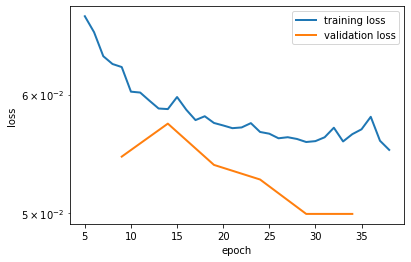

In [ ]:
#@title
## Epoch 48 | Training loss: 3.9255 Epoch 49 | Training loss: 3.9356

import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

* Save the trained model

In [ ]:
# Save the pre-trained model
path = filepath + '/trained_model/ieee118ac_trained_params.pickle'
torch.save(net.state_dict(), path)

# Evaluate the model w/ validation set

In [ ]:
print(x_test.shape)
n_test = np.size(x_test,2)
print(n_test)

(118, 3, 1051)
1051


In [ ]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

n_test = np.size(x_test,2)

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([1051, 3, 118])
Number of validation set:  1051


 - Evaluate the trained model using validation set and visualize error

In [ ]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(118, 1051)


In [ ]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

err_expand = []
for i in range(10):
  err_expand.append(err_L2)
err_expand = np.array(err_expand)
print(err_L2.shape,err_expand.shape)

(1051,) (10, 1051)


# Visualization




L2 mean: 0.10246643853653283 L2 variance: 0.001956527312597969 L_inf mean: 0.246553711306049


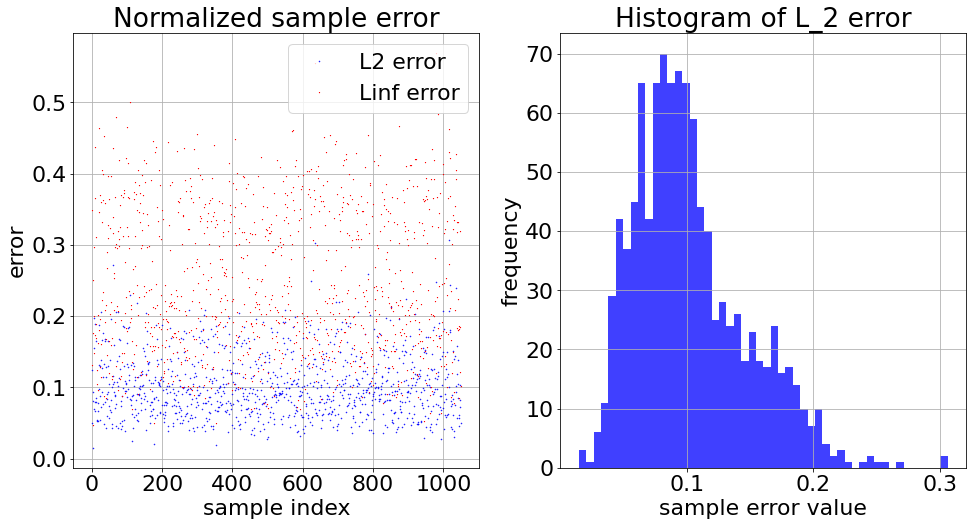

In [ ]:
err_L2_mean = np.mean(err_L2)
err_L2_var = np.var(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

plt.rcParams.update({'font.size': 22})
fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Validate datasets with topology changes

In [ ]:
print(gen_pert[0].shape)

def graph_laplacian(line,n_line,n_bus):
	incidence = np.zeros((n_line,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		incidence[i,int(line[i,0])-1] = incidence[i,int(line[i,0])-1] + 1 # source
		incidence[i,int(line[i,1])-1] = incidence[i,int(line[i,1])-1] - 1 # destination
	w = np.matmul(incidence.transpose(),incidence)
	return w

# print(line_bus)
line_bus1 = np.delete(line_bus,0,0) # input: array, ojb, axis
# print(line_bus1)
W1 = graph_laplacian(line_bus1,n_line-1,n_bus) # v2v

(118, 7000)


In [ ]:
print(effective_index.shape)

(7000, 10)


In [ ]:
# gen_pert

load_data = x.copy()

load_e = []
for n_idx in range(topo_pert_num):
  # effective_samples = [5999,5994,5997,5992,5992]
  load_e1 = np.zeros((n_bus,3,effective_samples[n_idx]))
  idx = 0
  for i in range(np.size(load_data,1)):
    if effective_index[i][n_idx + 1] > 0:
      idx = idx + 1 
      load_e2 = load_data[:,:,i].copy()
      load_e1[:,:,idx - 1] = load_e2.copy()
  load_e.append(load_e1)
print(idx,load_e1.shape,load_data.shape)

3 (118, 3, 7000) (118, 3, 7000)


In [ ]:
for i in range(topo_pert_num):
  print(load_e[i].shape,gen_pert[i].shape)

(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)
(118, 3, 7000) (118, 7000)


In [ ]:
filename = filepath + '118ac_recorded_deletion_idx.txt' # load file (no gen)
del_idx = pd.read_table(filename,sep=',',header=None).to_numpy()
print(del_idx.shape)
del_num = np.sum(del_idx,0)
print(del_num.shape)
print(del_num)

(186, 9)
(9,)
[2 2 1 1 1 1 1 1 2]


In [ ]:
print(del_idx[:,0])
# for i in range(5,0,-1):
#   print(i-1)
x_feed = torch.from_numpy(np.transpose(load_e[idx])).float()
x_feed = x_feed#.transpose(1,2)
print(local_batch.shape,x_feed.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
torch.Size([149, 3, 118]) torch.Size([7000, 3, 118])


In [ ]:
err_L2_tot = []
err_Linf_tot = []

net=net.cpu()

for idx in range(topo_pert_num):
  x_feed = torch.from_numpy(np.transpose(load_e[idx])).float()
  # x_feed = x_feed.unsqueeze_(-1).transpose(1,2)

  line_bus1 = line_bus.copy()
  for i in range(n_line,0,-1):
    if del_idx[i-1,idx] > 0:
      line_bus1 = np.delete(line_bus1,i-1,0) # input: array, ojb, axis

  W1 = graph_laplacian(line_bus1,n_line-del_num[idx],n_bus) # v2v

  net_new = GCN(3, w_params,W1, n_bus) # Laplacian
  path = filepath + 'trained_model/' + 'ieee118ac_trained_params.pickle'
  net_new.load_state_dict(torch.load(path))

  y_pred1 = net(x_feed) # prediction
  y_pred1 = y_pred1.detach()
  y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

  y_test00 = gen_pert[idx].copy()
  y_test = y_test00[:,0:effective_samples[idx]].copy()
  # print(y_test.shape,y_pred1.shape)

  n_test = np.size(y_test,1)
  err_L2 = np.zeros(n_test)
  err_Linf = np.zeros(n_test)
  for i in range(n_test):
    err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
    err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

  err_L2_tot.append(err_L2)
  err_Linf_tot.append(err_Linf)

In [ ]:
# for i in range(topo_pert_num):
#   print(err_L2_tot[i].shape)
print(err_expand.shape)
err_expand1 = err_expand.reshape(1051*10).tolist()

(10, 1051)


# Validation visualization

In [ ]:
#@title


L2 mean: 0.9870068834880797 L2 variance: 2.566038729440842e-07 L_inf mean: 0.9888722449010238
L2 mean: 0.9869996348647789 L2 variance: 2.5144797714728443e-07 L_inf mean: 0.9888710876426013
L2 mean: 0.9870044327755488 L2 variance: 2.55098565664695e-07 L_inf mean: 0.9888719257906076
L2 mean: 0.9870044327755488 L2 variance: 2.55098565664695e-07 L_inf mean: 0.9888719257906076
L2 mean: 0.9870044327755488 L2 variance: 2.55098565664695e-07 L_inf mean: 0.9888719257906076
L2 mean: 0.9870044327755488 L2 variance: 2.55098565664695e-07 L_inf mean: 0.9888719257906076
L2 mean: 0.9870577949606655 L2 variance: 2.549620322676645e-07 L_inf mean: 0.9888746980859522
L2 mean: 0.9870044327755488 L2 variance: 2.55098565664695e-07 L_inf mean: 0.9888719257906076
L2 mean: 0.9870035766426751 L2 variance: 2.5439583102400615e-07 L_inf mean: 0.9888716237325733


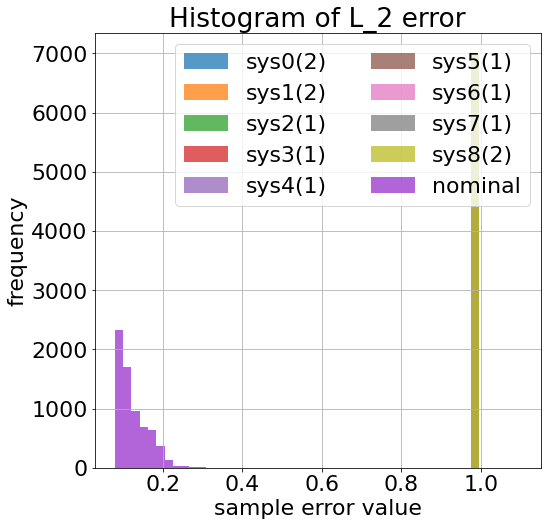

In [ ]:
##@title
for i in range(topo_pert_num):
  err_L2_mean = np.mean(err_L2_tot[i][0:5950])
  err_L2_var = np.var(err_L2_tot[i][0:5950])
  err_Linf_mean = np.mean(err_Linf_tot[i][0:5950])
  print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

plt.rcParams.update({'font.size': 22})
fig2 = plt.figure(figsize=(8, 8))
bins = np.linspace(0.08, 1.1, 50)
for i in range(topo_pert_num):
  name = 'sys' + str(i) + '('+ str(del_num[i]) + ')'
  plt.hist(err_L2_tot[i], bins, alpha = 0.75, label = name)
name = 'nominal'
plt.hist(err_expand1, bins, alpha = 0.75, label = name, color='darkorchid')
plt.legend(loc='upper right',ncol=2)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Use pre-trained net as warm start
* We only select a few datasets w/ large deviation
* 2,3,8,9,12

In [ ]:
##@title
# net.state_dict()  # parameters
import copy
net_copy =  copy.deepcopy(net) # net.copy()
# print(net_copy)

path = filepath + 'trained_model/' + 'ieee118ac_trained_params.pickle'
torch.save(net.state_dict(), path)
# model = TheModelClass(*args, **kwargs)
net_new = GCN(3, w_params, W, n_bus) # Laplacian
net_new.load_state_dict(torch.load(path))
# model.eval()

<All keys matched successfully>

In [ ]:
##@title
# train_key = [2,3,8,9,12]
train_key = [i for i in range(9)]
# train_key = [2]
device = torch.device('cpu')
max_epochs = 5

n_t = 6000

trainging_loss_topo = []
L2_loss = []
net_list = []

for idx in train_key:
  print('......')
  print('Start training for network:',idx)
  print('......')

  # Dataset Generators
  # x_train11 = []
  x_train11 = load_e[idx].copy()
  x_train11 = x_train11[:,:,:n_t]
  # x_train1 = torch.from_numpy(np.transpose(load_e[idx])).float()
  # y_test00 = []
  y_test00 = gen_pert[idx].copy()
  y_train11 = y_test00[:,0:effective_samples[idx]].copy()
  y_train11 = y_train11[:,:n_t]
  # print(x_train11.shape,y_train11.shape)

  x_train1 = x_train11
  x_test1 = x_train11
  y_train1 = y_train11
  y_test1 = y_train11

  # print(x_train1.shape,y_train1.shape)

  training_set = Dataset(features=x_train1, labels=y_train1)
  training_generator = torch.utils.data.DataLoader(training_set, **params)

  # generate Laplacian matrix
  line_bus1 = line_bus.copy()
  for i in range(n_line,0,-1):
    if del_idx[i-1,idx] > 0:
      line_bus1 = np.delete(line_bus1,i-1,0) # input: array, ojb, axis
  W1 = graph_laplacian(line_bus1,n_line-del_num[idx],n_bus) # v2v

  # generate a new net and import pre-trained net
  net_new = GCN(3, w_params,W1, n_bus) # Laplacian
  net_new.load_state_dict(torch.load(path))

  # set the optimizer
  optimizer = torch.optim.Adam(net_new.parameters())

  # re-train the model
  loss_optm = []
  for epoch in range(max_epochs):
      # training loop
      train_loss=0.0
      for local_batch, local_labels in training_generator:
          # Transfer to GPU
          local_batch, local_labels = local_batch.to(device), local_labels.to(device)
          # print(local_batch.shape)
          # print(local_batch)
          # print(local_labels.shape)
          logits = net_new(local_batch) # laplacian
          loss = loss_func(logits, local_labels)
          loss.backward()
          train_loss+=loss.item()
          optimizer.step()  # update parameters of net
          optimizer.zero_grad()  # clear the psat gradient
      loss_optm.append(train_loss/len(training_generator.dataset))
      print("Epoch %d | Training loss: %.4f" % (epoch, train_loss/len(training_generator.dataset)))
      # print("Epoch %d | Loss: %.4f" % (epoch, loss.item()))
      # loss_optm.append(loss.item())
      # validation loop
      with torch.set_grad_enabled(False):
          pass

  trainging_loss_topo.append(loss_optm)

  # store the trained model params
  net_list.append(net_new)
  path1 = filepath + 'trained_model/'
  name = 'ieee118ac_trained_params_sys' + str(idx) + '.pickle'
  torch.save(net_new.state_dict(), path1+name)
  
  x_feed = torch.from_numpy(np.transpose(x_test1)).float()
  # x_feed = x_feed.unsqueeze_(-1).transpose(1,2)
  y_pred1 = net_new(x_feed) # prediction
  y_pred1 = y_pred1.detach()
  y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

  # calculate the error
  n_test = np.size(y_test1,1)
  err_L2 = np.zeros(n_test)
  err_Linf = np.zeros(n_test)
  print(n_test,y_test1.shape,y_pred1.shape)
  for i in range(n_test):
    err_L2[i] = np.linalg.norm(y_pred1[:,i] - y_test1[:,i]) / np.linalg.norm(y_test1[:,i])
    err_Linf[i] = np.max(np.abs(y_pred1[:,i] - y_test1[:,i])) / np.max(np.abs(y_test1[:,i]))
  
  L2_loss.append(err_L2)
  err_L2_mean = np.mean(err_L2[:5950])
  err_L2_var = np.var(err_L2[:5950])
  err_Linf_mean = np.mean(err_Linf[:5950])
  print('......')
  print('System',idx)
  print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

......
Start training for network: 0
......


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 | Training loss: 77.2191
Epoch 1 | Training loss: 42.5308
Epoch 2 | Training loss: 10.2408
Epoch 3 | Training loss: 1.2295
Epoch 4 | Training loss: 0.6088
6000 (118, 6000) (118, 6000)
......
System 0
L2 mean: 0.06268949397967565 L2 variance: 0.0024796716031783564 L_inf mean: 0.12554147035377305
......
Start training for network: 1
......
Epoch 0 | Training loss: 77.1707
Epoch 1 | Training loss: 42.5625
Epoch 2 | Training loss: 7.4585
Epoch 3 | Training loss: 0.9688
Epoch 4 | Training loss: 0.5251
6000 (118, 6000) (118, 6000)
......
System 1
L2 mean: 0.0620823297683356 L2 variance: 0.0019481862437709728 L_inf mean: 0.12382125785589201
......
Start training for network: 2
......
Epoch 0 | Training loss: 77.1990
Epoch 1 | Training loss: 43.6418
Epoch 2 | Training loss: 5.2598
Epoch 3 | Training loss: 0.6855
Epoch 4 | Training loss: 0.4992
6000 (118, 6000) (118, 6000)
......
System 2
L2 mean: 0.062323495175331756 L2 variance: 0.0017421217000529938 L_inf mean: 0.12474375685639437
..

In [ ]:
# load the post-processed nets


In [ ]:
# print(n_test)
# # for i in range(14):
# #   print(load_e[i].shape,gen_pert[i].shape,effective_samples[i])
# for i in range(5):
#   # print(L2_loss[i])
#   print(L2_loss[i].shape)
# load_e0[0:n_bus,:].transpose(), gen_nominal.transpose()

x_feed = torch.from_numpy(np.transpose(load_data)).float()
# x_feed = x_feed.unsqueeze_(-1).transpose(1,2)
y_pred1 = net(x_feed) # prediction
y_pred1 = y_pred1.detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()

# calculate the error
n_test = np.size(y_test1,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
print(n_test,y_test1.shape,y_pred1.shape)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_pred1[:,i] - y[:,i]) / np.linalg.norm(y[:,i])
  err_Linf[i] = np.max(np.abs(y_pred1[:,i] - y[:,i])) / np.max(np.abs(y[:,i]))
print(np.mean(err_L2[:5900]),np.mean(err_Linf[:5900]))

6000 (118, 6000) (118, 7000)
0.10197002859978985 0.24763213900119646


Nominal system:
L2 mean: 0.10197002859978985 L2 variance: 0.24763213900119646
......
Perturbed systems after post-prosessing:
Sys 0  |   L2 mean: 0.06263497317412837 L2 variance: 0.002469890855353792
Sys 1  |   L2 mean: 0.06203289338954856 L2 variance: 0.001942472532933274
Sys 2  |   L2 mean: 0.062274166972588224 L2 variance: 0.0017384345619625898
Sys 3  |   L2 mean: 0.06247471039508783 L2 variance: 0.0022832244512306244
Sys 4  |   L2 mean: 0.062211406907629635 L2 variance: 0.0015616576925485642
Sys 5  |   L2 mean: 0.06258722832820204 L2 variance: 0.002115335628743215
Sys 6  |   L2 mean: 0.06178414458669332 L2 variance: 0.0021171302649281055
Sys 7  |   L2 mean: 0.06207326317098775 L2 variance: 0.0015963402461315196
Sys 8  |   L2 mean: 0.062297508117756334 L2 variance: 0.001981904786543899


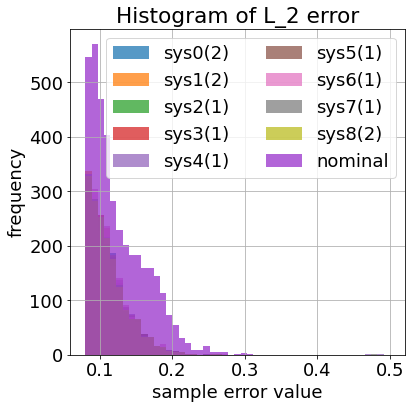

In [ ]:
# train_key = [2,3,8,9,12]
print('Nominal system:')
print('L2 mean:', np.mean(err_L2[:5900]),'L2 variance:', np.mean(err_Linf[:5900]))
print('......')
print('Perturbed systems after post-prosessing:')
for i in range(topo_pert_num):
  err_L2_mean = np.mean(L2_loss[i])
  err_L2_var = np.var(L2_loss[i])
  # err_Linf_mean = np.mean(err_Linf[i][0:5950])
  print('Sys',i,' |  ','L2 mean:', err_L2_mean,'L2 variance:', err_L2_var)#,'L_inf mean:', err_Linf_mean )

plt.rcParams.update({'font.size': 18})
fig2 = plt.figure(figsize=(6, 6))
bins = np.linspace(0.08, 0.5, 50)
for i in range(len(train_key)):
  name = 'sys' + str(train_key[i]) + '('+ str(del_num[train_key[i]]) + ')'
  plt.hist(L2_loss[i], bins, alpha = 0.75, label = name)
name = 'nominal'
plt.hist(err_L2, bins, alpha = 0.75, label = name, color='darkorchid')
plt.legend(loc='upper right',ncol=2)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()